# Run persistent homology
Running this notebook will:
- Use Ripser to get Betti bar codes from saved rates. 
- If nCells > 10, dim reduce spike counts using Isomap. 
- Threshold out low density points if thresholded is True.

**Ripster note:** required ripser package version can be installed on Ubuntu with:
```
pip install Cython
pip install ripser==0.3.2
```

## Setup

In [2]:
# General imports
import sys, os
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ripser import ripser as tda

# Set random seed and get current date
sd = int((time.time()%1)*(2**31))
np.random.seed(sd)
curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'

# Import shared scirpts
gen_fn_dir = os.path.abspath('.') + '/shared_scripts'
sys.path.append(gen_fn_dir)

import general_file_fns as gff
from binned_spikes_class import spike_counts
from dim_red_fns import run_dim_red
from scipy.spatial.distance import pdist
from sklearn import neighbors

# Load general params
gen_params = gff.load_pickle_file('./general_params/general_params.pkl')

# Create directory for results
save_dir = gff.return_dir(gen_params['results_dir'] + "/TDA")

# Set up parameters
session = 'Mouse28-140313'
state = 'Wake'
thresholded = False
area = 'ADn'
dt_kernel = 0.1
sigma = 0.1
smoothing_window = 10 
rate_params = {'dt': dt_kernel, 'sigma': sigma}
print(('Session: %s, state: %s' % (session, state)))

Reading data from ./general_params/general_params.pkl...
Reading data from ./general_params/general_params.pkl...
Session: Mouse28-140313, state: Wake


### Load and smooth kernel rates
Smooth rates are "downsampled", averaged over some window rates.

In [3]:
session_rates = spike_counts(session, rate_params, count_type='rate',anat_region=area)
rates_all = session_rates.get_spike_matrix(state)[0]
nCells_tot = rates_all.shape[1]
print(f"Loaded {rates_all.shape[0]} rates for each of {nCells_tot} cells.")

Loading spike counts from ./data/analyses/kernel_rates/100ms_sigma/Mouse28-140313.pkl...
Reading data from ./general_params/area_shank_info.pkl...
Loaded 22864 rates for each of 22 cells.


In [4]:
n_smooth_samples = np.floor(len(rates_all) / smoothing_window).astype(int)
smooth_rates = np.zeros((n_smooth_samples, nCells_tot))
for i in range(n_smooth_samples):
    start_index = i * smoothing_window
    end_index = (i + 1) * smoothing_window
    smooth_rates[i] = np.mean(rates_all[start_index:end_index], axis=0)

print(f"Reduced number of rates to {smooth_rates.shape = }.")

Reduced number of rates to smooth_rates.shape = (2286, 22).


### If number of cells is greater than chosen fit_dim, reduce dimensionality
TODO: describe why this step

In [5]:
# If number of cells is greater than fit_dim, reduce dimensionality
fit_dim = 10
if nCells_tot > fit_dim:
    n_neighbors = 5
    dr_method = 'iso'
    dim_red_params = {'n_neighbors': n_neighbors, 'target_dim': fit_dim}
    print(f"Reducing dimensionality...")
    rates = run_dim_red(smooth_rates, params=dim_red_params, method=dr_method)
else:### 
    rates = smooth_rates

print(f"{rates.shape = }")

Reducing dimensionality...
rates.shape = (2286, 10)


### Apply thresholding if wanted
In so-called "thresholded TDA" part we eliminate outlier points by finding those with low neighbourhood density, i.e. we find all points in a specific radius abd if number of found neighbours is too low, we just remove point from dataset. Here we use radius equal to the 1st percentile of all pairwise distances between points and remove all points below 20th percentile in number of neighbours.

**Question:** How does thresholding affect the results? TODO.

In [6]:
if thresholded:
    # find number of neighbors of each point within radius of 1st percentile of all pairwise dist.
    dist = pdist(rates, 'euclidean')
    rad = np.percentile(dist, 1)
    neigh = neighbors.NearestNeighbors() # create instance of NearestNeighbours class 
    neigh.fit(rates)
    num_nbrs = np.array(list(map(len, neigh.radius_neighbors(X=rates, radius=rad,return_distance=False)))) # num_nbrs.shape = (rates.shape[0])

    # threshold out points with low density
    thresholded_prcnt = 20
    threshold = np.percentile(num_nbrs, thresholded_prcnt)
    thresholded_rates = rates[num_nbrs > threshold]
    rates = thresholded_rates
    print(f"After thresholding: {rates.shape = }")

## Computation of persistent homology
In this part we use `ripser` function from `ripser` module, version 0.3.2 (here imported as `tda`) to compute barcodes.

How it works?
- 


In [7]:
# Create dict for Betti numbers
results = {'session': session, 'h0': [], 'h1': [], 'h2': []}

# H0 & H1
tic = time.time()
barcodes = tda(rates, maxdim=1, coeff=2)['dgms'] # TODO describe this part
results['h0'] = barcodes[0]
results['h1'] = barcodes[1]
tok = time.time()
print(f"Computed H0 and H1 barcodes on all rates in {(tok-tic):.2f}s.")

Computed H0 and H1 barcodes on all rates in 57.78s.


In [8]:
# H2. Need to subsample points for computational tractability if number of points is large (can go higher but very slow).
max_num_rates = 150 # Changed it to 150 because I don't have enough RAM for 1500 and kernel dies.
if len(rates) >  max_num_rates:
    idx = np.random.choice(np.arange(len(rates)), max_num_rates, replace=False)
    H2_rates = rates[idx]
else:
    H2_rates = rates

tic = time.time()
barcodes = tda(H2_rates, maxdim=2, coeff=2)['dgms']
results['h2'] = barcodes[2]
tok = time.time()
print(f"Computed H0 and H1 barcodes on {len(H2_rates)} rates in {(tok-tic):.2f}s.")

Computed H0 and H1 barcodes on 150 rates in 0.77s.


In [11]:
# Save computed barcodes
save_to = save_dir + '%s_%s%s_ph_barcodes.p' % (session, state, ('_thresholded' * thresholded))
print(f"Saving barcodes to {save_to}")
gff.save_pickle_file(results, save_to)

Saving barcodes to ./data/analyses//TDAMouse28-140313_Wake_ph_barcodes.p
Data saved to ./data/analyses//TDAMouse28-140313_Wake_ph_barcodes.p.


1

### Plot barcodes

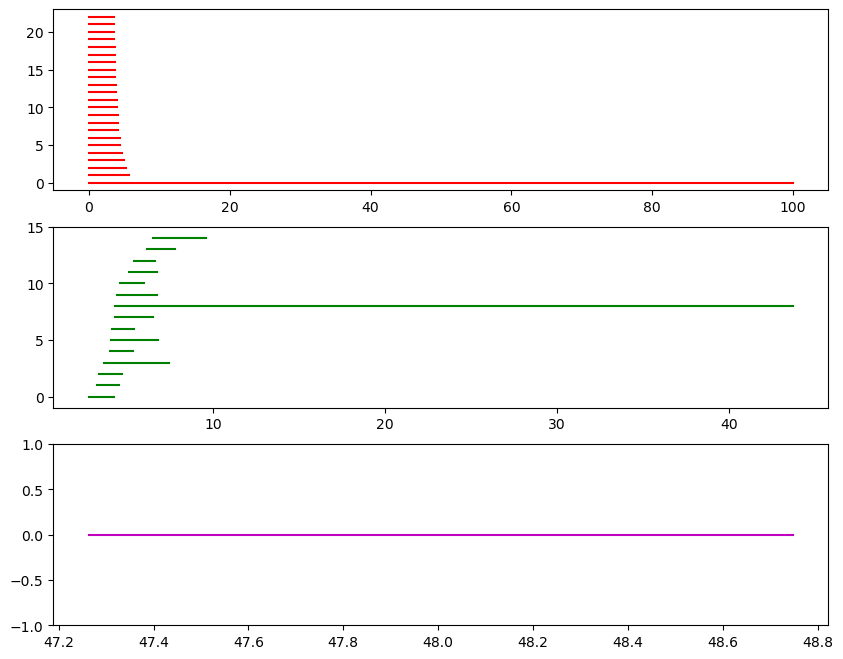

In [12]:
col_list = ['r', 'g', 'm', 'c']
h0, h1, h2 = results['h0'], results['h1'], results['h2']
# replace the infinity bar (-1) in H0 by a really large number
h0[~np.isfinite(h0)] = 100
# Plot the longest barcodes only
plot_prcnt = [99, 98, 90] # order is h0, h1, h2
to_plot = []
for curr_h, cutoff in zip([h0, h1, h2], plot_prcnt):
        bar_lens = curr_h[:,1] - curr_h[:,0]
        plot_h = curr_h[bar_lens > np.percentile(bar_lens, cutoff)]
        to_plot.append(plot_h)

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 4)
for curr_betti, curr_bar in enumerate(to_plot):
    ax = fig.add_subplot(gs[curr_betti, :])
    for i, interval in enumerate(reversed(curr_bar)):
        ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti],
            lw=1.5)
    # ax.set_xlim([0, xlim])
    # ax.set_xticks([0, xlim])
    ax.set_ylim([-1, len(curr_bar)])
    # ax.set_yticks([])
plt.show()
